# CNN Hands on:

This notebook represents a hands on tutorial for Convolutional Neural Networks (CNN). It will show you the basic concepts and how to implement them in python using tensorflow. In principle using and playing with CNNs does not require any large overhead or fancy computer system. You can directly start with your laptop if you like.  

Please note that this notebook shall only give you a first and does not replace a full lecture about machine learning. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

from simulator.toy_mc import NeutronVetoToyLightPropagator

In [2]:
pmts_in_z_slice = np.load('./data/toy_mc_pmt_positions.npy')

# Simple ToyMC example:

In [3]:
emission_point = np.array([[0, -90, 0]])
neutron_model = NeutronVetoToyLightPropagator(
    81.5, 
    pmts_in_z_slice,
    emission_point,
)

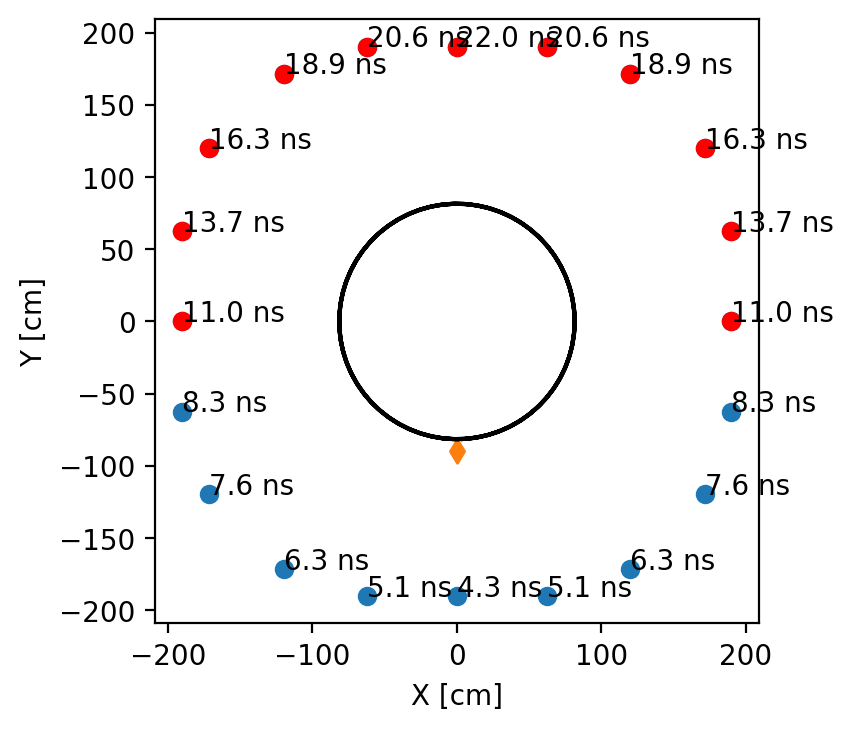

In [4]:
fig = neutron_model.plot_light_propagation(0)
fig.set_dpi(200)
fig

Background source position:

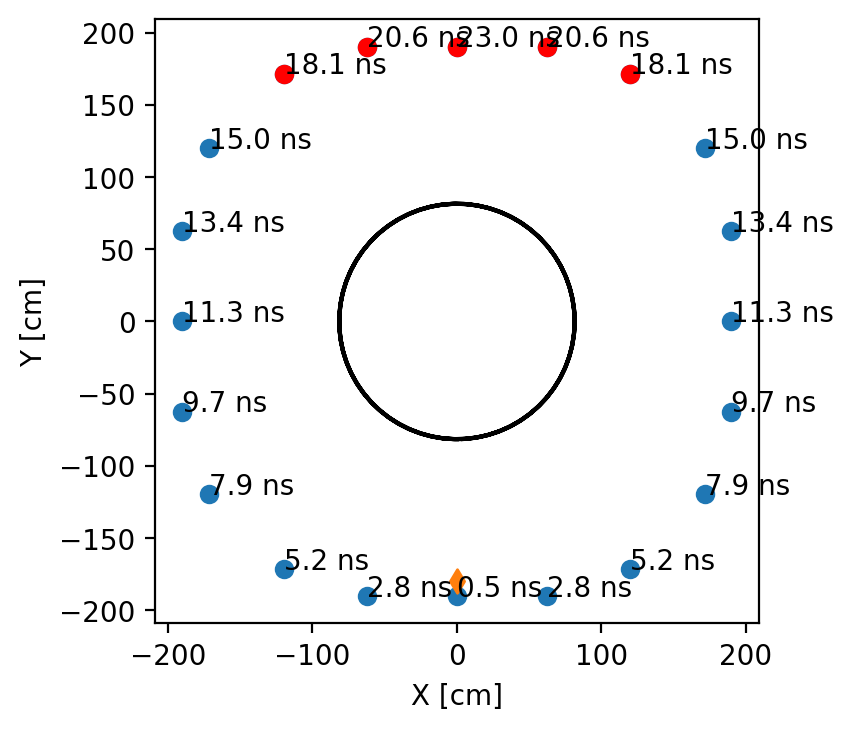

In [5]:
emission_point = np.array([[0, -180, 0]])
bkg_model = NeutronVetoToyLightPropagator(81.5, 
                                          pmts_in_z_slice,
                                          emission_point,
                                         )
fig = bkg_model.plot_light_propagation()
fig.set_dpi(200)
fig

### Light cone distribution:

As a next step we are going to create some toy events for the source positions we just specified before. To create events we can call the function `generate_events` which takes 5 arguments:

1. `n_events` simply represents how many events we would like to simulate. This number will therefore determine how large our training set is going to be.
2. `n_photons_per_event` represents the number of recorded photons per event. Please note that we wanted to stay simple for this tutorial. Hence, we do not apply any quantum efficiency nor photo-sensor threshold. The number of recorded photons are simply drawn from a Poisson distribution.
3. `spread_charge_distribtuion` mimics the spread of the photon charge distribution of our sensors. 
4. `lowest_charge_allowed` should mimic the detector threshold. None of the recorded photons can have a charge lower than this value.
5. `time_spread` allows to add some extra smearing to the photon arrival time after drawing a photosensor channel.

The function will return you 4 arrays. The first array is an offset array of the length `n_events`. It contains the information how many photons can be found in each individual event. This is necessary as the standard numpy library does not allow to store arrays with arbitrary lengths. This would require packages like [awkward arrays](https://awkward-array.org/quickstart.html) which are going beyond the scope of this tutorial.
The other three arrays are also flat arrays which have the length of the total sum of the offset array. Those arrays contain the time, channel and charge information for each individual photon. 

In [6]:
n_events = 10**3
n_photons_per_event = 26
spread_charge_distribtuion = 0.3
lowest_charge_allowed = 0.15


offsets_n, times_n, channel_n, areas_n = neutron_model.generate_events(n_events, 
                                                                       n_photons_per_event, 
                                                                       spread_charge_distribtuion, 
                                                                       lowest_charge_allowed)
n_ph_per_source_n = np.sum(offsets_n, axis=1)


offsets_bkg, times_bkg, channel_bkg, areas_bkg = bkg_model.generate_events(n_events, 
                                                                           n_photons_per_event, 
                                                                           spread_charge_distribtuion, 
                                                                           lowest_charge_allowed)
n_ph_per_source_bkg = np.sum(offsets_bkg, axis=1)

Let us know inspect a little bit the data with a simple histogram:

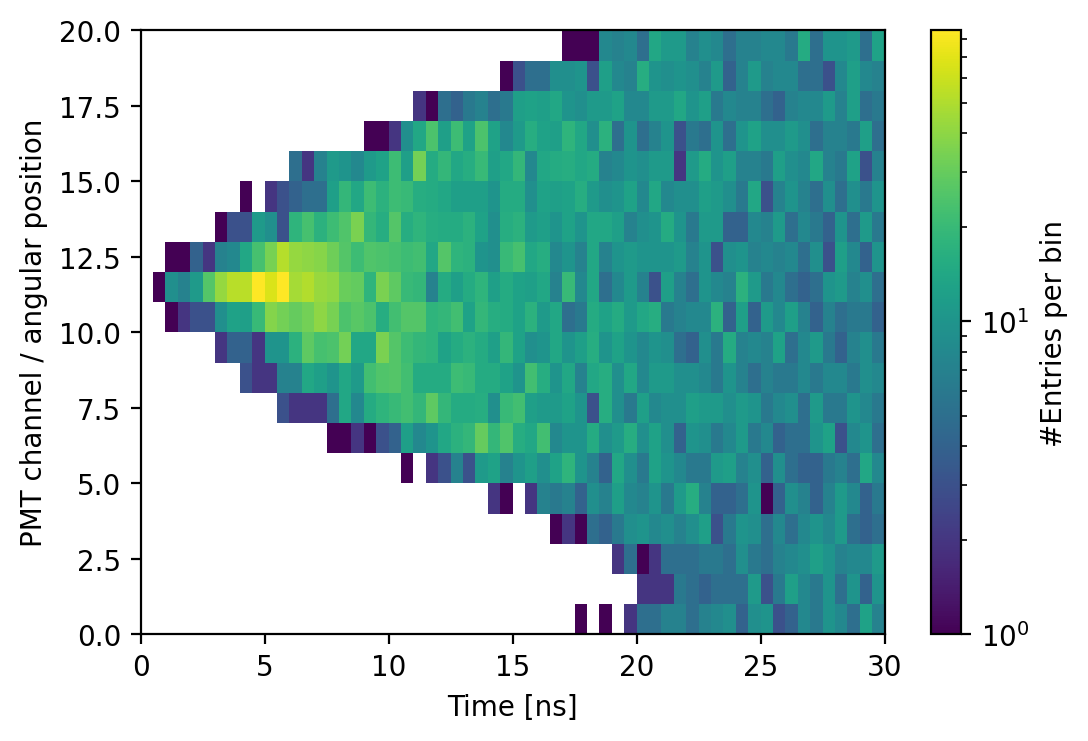

In [7]:
plt.figure(dpi=200)
plt.hist2d(times_n, 
           channel_n,
           bins=(60, 20), range=((0, 30), (0, 20)),
           norm=matplotlib.colors.LogNorm()
          )
plt.colorbar(label='#Entries per bin')
plt.xlabel('Time [ns]')
plt.ylabel('PMT channel / angular position')
plt.show()

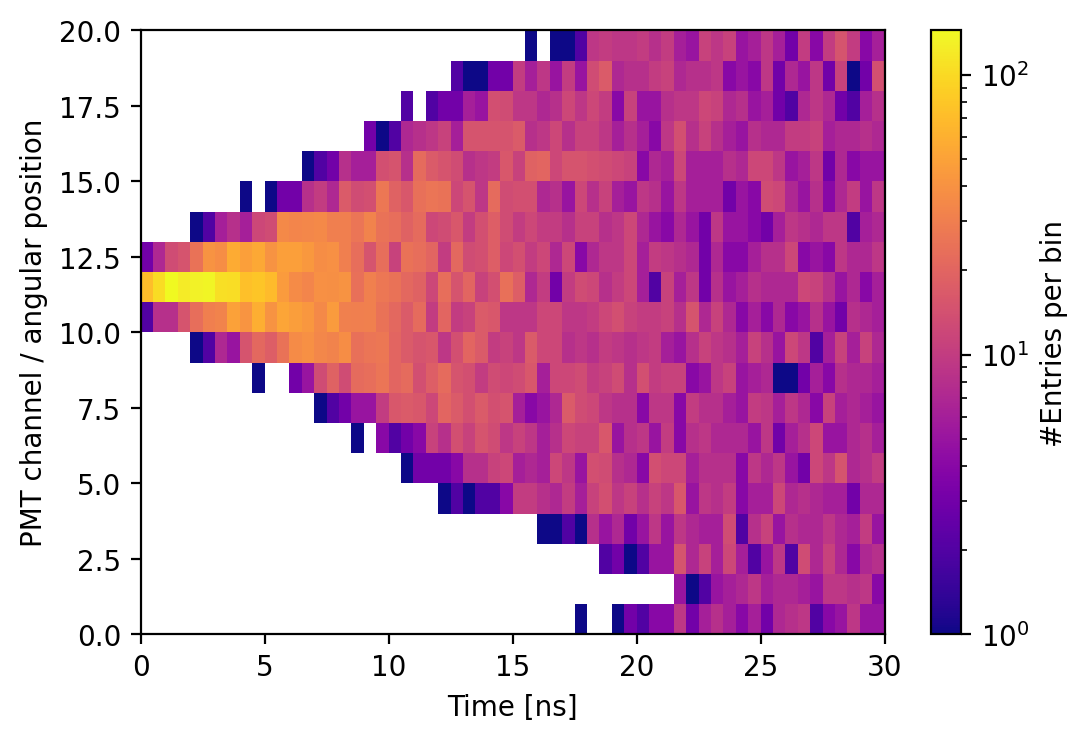

In [8]:
plt.figure(dpi=200)
plt.hist2d(times_bkg, 
           channel_bkg,
           bins=(60, 20), range=((0, 30), (0, 20)),
           norm=matplotlib.colors.LogNorm(),
           cmap='plasma'
          )
plt.colorbar(label='#Entries per bin')
plt.xlabel('Time [ns]')
plt.ylabel('PMT channel / angular position')
plt.show()

You can see that both background and neutrons follow a cone shaped like structure which differs a bit in shape. This difference in shape is what we would like to exploit for our classification.

If you like you can play a bit and try to plot the spatial time distributions for different source positions.

### Create images:

Before we can start implementing our first CNN we have to convert our toy MC data into images. Therefore let us create a first a small set of additional data....

In [9]:
n_events = 1*10**3
n_ph = 25
photon_charge_resolution = 0.3
photon_charge_threshold = 0.15  

offsets_n, times_n, channel_n, charge_n = neutron_model.generate_events(n_events, 
                                                                        n_ph,
                                                                        photon_charge_resolution,
                                                                        photon_charge_threshold,
                                                                       )

offsets_bkg, times_bkg, channel_bkg, charge_bkg = bkg_model.generate_events(n_events, 
                                                                            n_ph,
                                                                            photon_charge_resolution,
                                                                            photon_charge_threshold,
                                                                           )


... which we will now convert into some images using the following function:

In [10]:
images_n = neutron_model.make_sample(offsets_n, 
                                     times_n, 
                                     channel_n, 
                                     charge_n, 
                                     time_bins=np.arange(0, 32.1, 2)
                                    )
images_bkg = bkg_model.make_sample(offsets_bkg, 
                                   times_bkg, 
                                   channel_bkg, 
                                   charge_bkg, 
                                   time_bins=np.arange(0, 32.1, 2)
                                  )

We can also display some of these images:

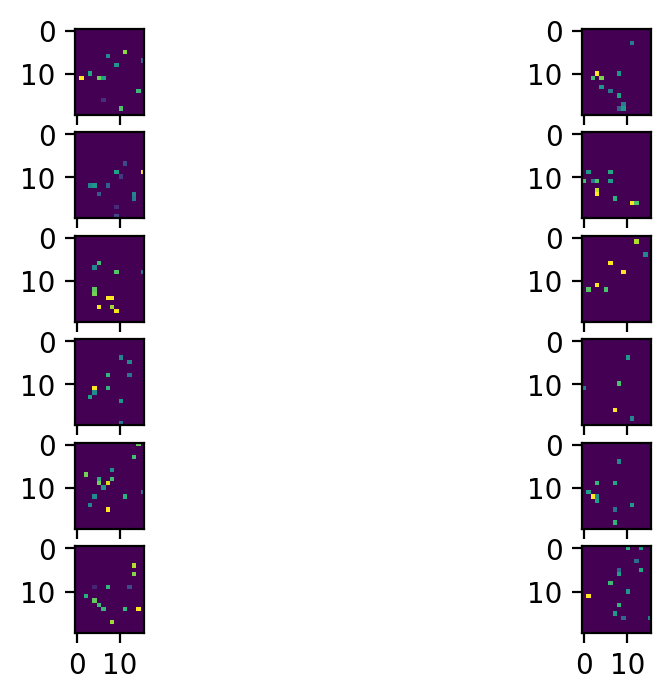

In [11]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=200, sharex=True)
for ind, (i_n, i_g) in enumerate(zip(images_n[:6], images_bkg[:6])):
    axes[ind, 0].imshow(i_n)
    axes[ind, 1].imshow(i_g)

In [12]:
images_n.shape

(1000, 20, 16)

As you can see created now 1k images with a shape of 20 x 16 for both our neutrons and our background. Can you tell which image belongs to which source?

## Image preprocessing:

In most Convolutional Neural Network applications images from our daily life are used. E.g. for the recognition of street signs. Usually these images can have different shapes and color-scaling which makes image preprocessing for those applications a very important point. In our example we know already that all images are going to have the very same shape. This should be true for most of detector based applications.  

However also for our data we have to perform two task for our image preprocessing.

### Normalization:

Normalization is simple. We just have to make sure that the "gray-scale" (measured charge per pixel) of our images are well defined. E.g. that all charge values are normalized to the range between (0, 1). 

In [13]:
max_charge_n = np.max(images_n)
images_n /= max_charge_n

max_charge_bkg = np.max(images_bkg)
images_bkg /= max_charge_bkg

### Data labeling and splitting:

The second task we have to perform is to label our data and split it into a training and a validation data set. Let us start with the labeling. Using labeled data is one of the approaches how we can teach our computer how to perform a certain task. The algorithm will try to predict to which of our categories an images belongs to and compares it with its corresponding label. Depending whether the prediction was correct or not the algorithm will adjust itself. 

To label our data we have to create an array filled with zeros of the size `n x m` where `n` represents the number of images we have and `m` the number of categories. In case an image `n_i` belongs to the category `m_i` we set the corresponding value to 1. E.g. that our labels look like

```
0, 1, 0, 0,
1, 0, 1, 1,
```

assuming that only the second image belongs to the first category. 

In [14]:
fraction_training = 0.8

assert len(images_n) == len(images_bkg)
n_events = len(images_n)

# Make common image buffer:
images = np.concatenate([images_n, images_bkg])

# Create labels for images:
image_labels = np.zeros((2*n_events, 2), dtype=np.int8)
image_labels[:n_events, 0] = 1
image_labels[n_events:, 1] = 1

After labeling our data we should shuffle it. Usually we will train our CNN in batches of a certain size and we should make sure that each batch contains images of the different categories. Hence let us shuffle our images and labels:

In [15]:
# Shuffle data and create training and validation set:
inds = np.arange(0, 2*n_events, 1)
np.random.shuffle(inds)
images = images[inds]
image_labels = image_labels[inds]

Last but not least we should split our data in a training and a validation data set. As the names suggest the training data set is only used for the training of our CNN while the validation data is used for validating our algorithm. We will also see in  a bit why the validation plays an important role.

Usually, people recommend to use a 80:20 splitting so let use this one for the moment. 

In [16]:
n_training = int(n_events*fraction_training)
images_training = images[:n_training]
labels_training = image_labels[:n_training]

n_valid = n_events - n_training
images_validation = images[-n_valid:]
labels_validation = image_labels[-n_valid:]

Let us check once more a few images. Can we train your brain to distinguish neutrons from background when we provide you with images and labels? 

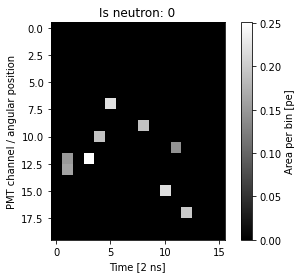

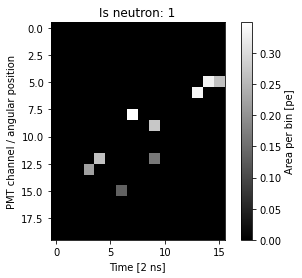

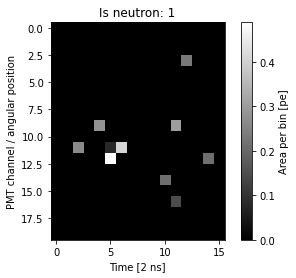

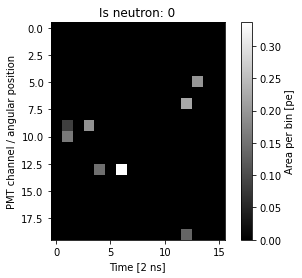

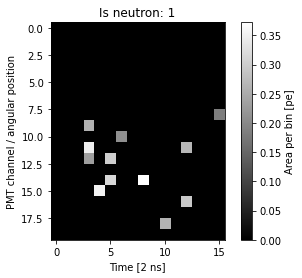

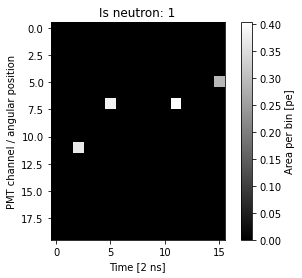

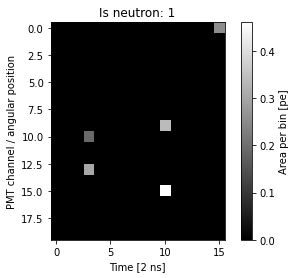

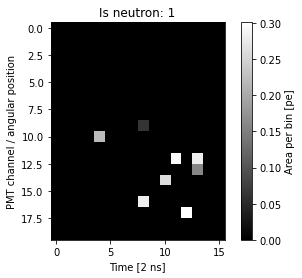

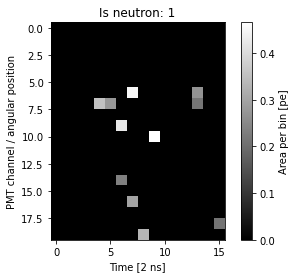

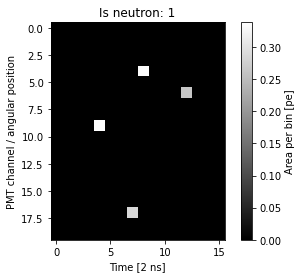

In [17]:
for i in range(10):
    plt.figure()
    plt.title(f'Is neutron: {labels_training[i, 0]}')
    image = plt.imshow(images_training[i], cmap='gray')
    plt.xlabel('Time [2 ns]')
    plt.ylabel('PMT channel / angular position')
    plt.colorbar(image, label='Area per bin [pe]')

# Your first NN:

Okay after we prepared now our data we can start with your first Neural Network. In this tutorial we are going to use tensorflow to set up our Neural Network. Typically, a neural net is composed of a sequential stack of different layers. Each layer can perform a different task depending on the application. Let us start with something simple which is made out of set of different dense layers.

In [18]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

2022-04-08 10:58:15.358277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/XENONnT/anaconda/envs/XENONnT_development/lib64:/opt/XENONnT/anaconda/envs/XENONnT_development/lib:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib:/opt/rh/devtoolset-9/root/usr/lib64/dyninst:/opt/rh/devtoolset-9/root/usr/lib/dyninst:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib
2022-04-08 10:58:15.358309: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


You can set-up a sequence of layers by initializing...

In [19]:
my_first_nn = Sequential()

2022-04-08 10:58:17.221587: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/XENONnT/anaconda/envs/XENONnT_development/lib64:/opt/XENONnT/anaconda/envs/XENONnT_development/lib:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib:/opt/rh/devtoolset-9/root/usr/lib64/dyninst:/opt/rh/devtoolset-9/root/usr/lib/dyninst:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib
2022-04-08 10:58:17.221616: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-08 10:58:17.221640: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (midway2-0414.rcc.local): /proc/driver/nvidia/version does not exist
2022-04-08 10:58:17.221901: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFl

and simply adding layers to the sequence:

In [20]:
my_first_nn.add(Flatten(input_shape=(20, 16, 1)))
my_first_nn.add(Dense(100, activation='relu'))
my_first_nn.add(Dense(50, activation='relu'))
my_first_nn.add(Dense(2, activation='softmax'))

In this particular example we are just adding two different types of layer a `Flatten` layer and a `Dense` layer. The `Flatten` layer as the name suggest converts an array/image of an arbitrary size into a flat array. This has to be done depending on the output form of the desired sequence. 

The `Dense` layer is the typical layer of neurons which you might have in mind when thinking of neural networks. A dense layer is fully connected with all outputs of the previous and all inputs of the next layer. For each of the connections our neural network is parameterized by a so called weight parameter `w_i`. In addition each neuron has an additional bias term `b_i`. 
 
When ever you make a new model it make sense to quickly print its statistics via:

In [21]:
my_first_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 100)               32100     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 37,252
Trainable params: 37,252
Non-trainable params: 0
_________________________________________________________________


Our current model has about 37k parameters which we have to train. The number of parameters depends on the number of weights and bias terms mentioned above in our current example we are doing the following:

1. We flatten our image from a size 20 x 16 x 1 into single dimensional array of the size 320. 
2. We connect all the 320 outputs of the flatten layer with the 100 neurons of our dense layer. Hence, we are getting 32000 parameters due to weights and an other 100 due to one bias term per neuron. 
3. In the next step we are connecting our 100 outputs with the 50 neurons of the next layer. Which gives another 5000 weights plus 50 bias terms.
4. The last layer should represent our output. Since we are trying to categorize our data we only need here one neuron per category. In our case just two. Therefore, we will get another 102 parameters.

You may also have noticed that with each dense layer we passed an additional keyword argument called `activation`. I will explain in a few cells what this keyword argument does. For now let us compile our model such that we can use it to classify our data.

When compiling our data we have to specify the loss function and the optimizer which should be used. In general you can think of the loss function as something similar to a negative Log-Likelihood or Least Squares function which you are used to when fitting a model onto some data points. In both cases fitting and machine learning the goal is to minimize the loss function to achieve the best possible result. In our example we will use `keras.losses.binary_crossentropy` which represents the binary cross entropy of our categories. Depending on your application you have to replace this loss function with a different one.

In addition to the loss function one also has to specify the `optimizer` which should be used to find the minimum in our loss function. In general one can find the minimum of a loss function by moving into the direction of the negative gradient of the loss function. There are many different methods to compute the gradient e.g. `stochastic gradient descent`.

In many cases the so called `Adam` (Adaptive Movement Estimation) optimizer is recommended.  

In [22]:
my_first_nn.compile(loss=keras.losses.binary_crossentropy, 
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy']
                   )

After compiling our model we can check how good it performs on our data. Lets try to see with which probability the first images is predicted to be a neutron or not. We can get a prediction by our model by simply using the `.predict` method.

In [23]:
prediction = my_first_nn.predict(images[:100])
print('Predicted probability that the first image is a neutron '
      f' {prediction[0, 0]*100:.1f} % instead of background.')

Predicted probability that the first image is a neutron  49.0 % instead of background.


A 50:50 chance that the image is a neutron image or not is not really helpful yet. Lets try with a larger sample. Attached with this tutorial you can find a file called `tools.py` which contains a with helper function for the analysis of our model. 
For now we just need `get_correaltion` and `plot_confusion_matrix` to compute the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of our data.  

In [24]:
from tools import get_correaltion, plot_confusion_matrix

So now let us check the predictions for the first 100 images.

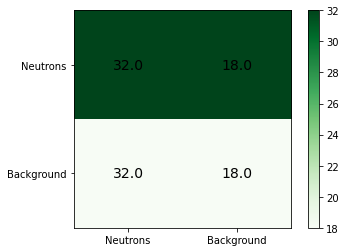

In [25]:
cm = get_correaltion(prediction, image_labels[:100])
fig = plot_confusion_matrix(cm, ['Neutrons', 'Background'])

You can see that our model does not really perform very well and many images are categorized as false positives (background being classified as neutrons) and false negatives (neutrons being classified as background). The reason for this poor performance comes from the fact that we have not trained our model yet. 

We can try our neural net using the fit method of our model. As arguments we have to pass our training and validation images as well as the so-called **batch size** and the number of **epochs** we would like to train our data. 

The **batch size** represents the number of inputs/images to be used to compute the negative gradient of our log-function. A larger batch size will result in a more precise estimate of the gradient. However, a too large batch size may lead to a slower learning rate as we only move only along the negative gradient once it is computed. Batch size typically are given in units of $2^n$. 

The number of **epochs** represents how often we will repeat the training of our neural net using our input data. Each time the input is shuffled again before training another epoch.

Let us train our simple model with 128 images per batch for 100 epochs:

In [26]:
batch_size = 128
epochs = 100

In [27]:
training_statistics = my_first_nn.fit(images_training, 
                                      labels_training, 
                                      batch_size=batch_size, 
                                      epochs=epochs,  
                                      validation_data=(images_validation, labels_validation),
                                     )

Epoch 1/100
7/7 [==============================] - 1s 26ms/step - loss: 0.6912 - accuracy: 0.5675 - val_loss: 0.6891 - val_accuracy: 0.6150
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6828 - accuracy: 0.7325 - val_loss: 0.6848 - val_accuracy: 0.6900
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6737 - accuracy: 0.7912 - val_loss: 0.6783 - val_accuracy: 0.7100
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6617 - accuracy: 0.7925 - val_loss: 0.6699 - val_accuracy: 0.7250
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6444 - accuracy: 0.8100 - val_loss: 0.6584 - val_accuracy: 0.7300
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6204 - accuracy: 0.8250 - val_loss: 0.6428 - val_accuracy: 0.7500
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 0.5868 - accuracy: 0.8375 - val_loss: 0.6218 - val_accuracy: 0.7300
Epoch 8/100
7/7 [=========

7/7 [==============================] - 0s 6ms/step - loss: 0.0113 - accuracy: 0.9987 - val_loss: 1.1592 - val_accuracy: 0.7300
Epoch 60/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0108 - accuracy: 0.9987 - val_loss: 1.1675 - val_accuracy: 0.7250
Epoch 61/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0101 - accuracy: 0.9987 - val_loss: 1.1787 - val_accuracy: 0.7250
Epoch 62/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0097 - accuracy: 0.9987 - val_loss: 1.1873 - val_accuracy: 0.7300
Epoch 63/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0092 - accuracy: 0.9987 - val_loss: 1.1942 - val_accuracy: 0.7250
Epoch 64/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 1.2027 - val_accuracy: 0.7250
Epoch 65/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 1.2135 - val_accuracy: 0.7250
Epoch 66/100
7/7 [===============

Based on the printout we can see that the accuracy of our model is 100 %. When computing the confusion matrix it looks indeed like our model makes a perfect prediction. 

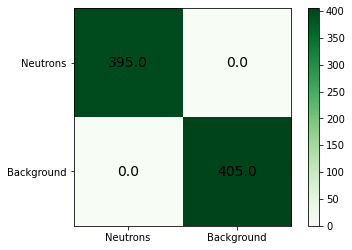

In [28]:
prediction = my_first_nn.predict(images_training)
cm = get_correaltion(prediction, labels_training)
fig = plot_confusion_matrix(cm, ['Neutrons', 'Background'])

Let repeat the exercise for our validation data:

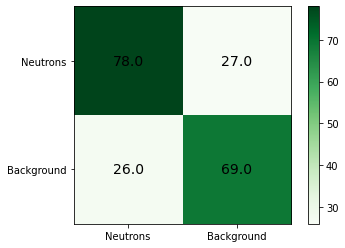

In [29]:
prediction = my_first_nn.predict(images_validation)
cm = get_correaltion(prediction, labels_validation)
fig = plot_confusion_matrix(cm, ['Neutrons', 'Background'])

In [30]:
(cm[1,0] + cm[0,1])/np.sum(cm)

0.265

In case of our validation data we get an accuracy of just 40 %? During training the results of our fitting history are stored in `training_statistics`. So let us have a look into the accuracy and loss for the training and validation data:

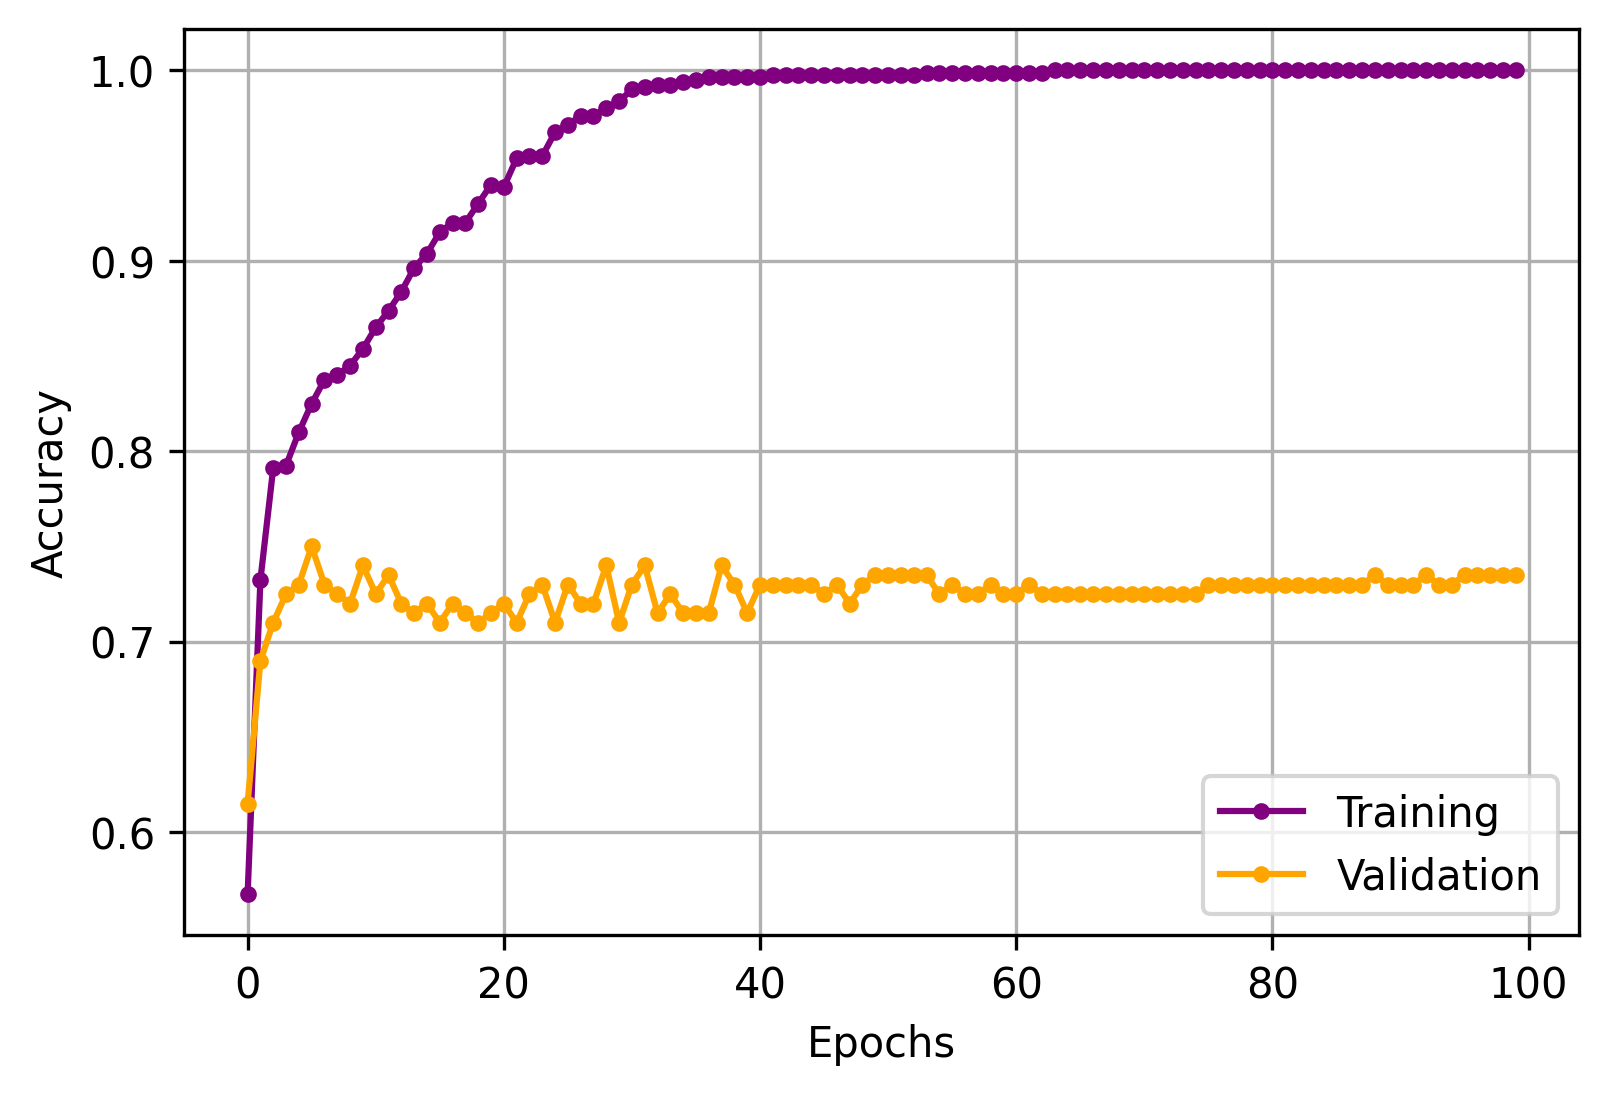

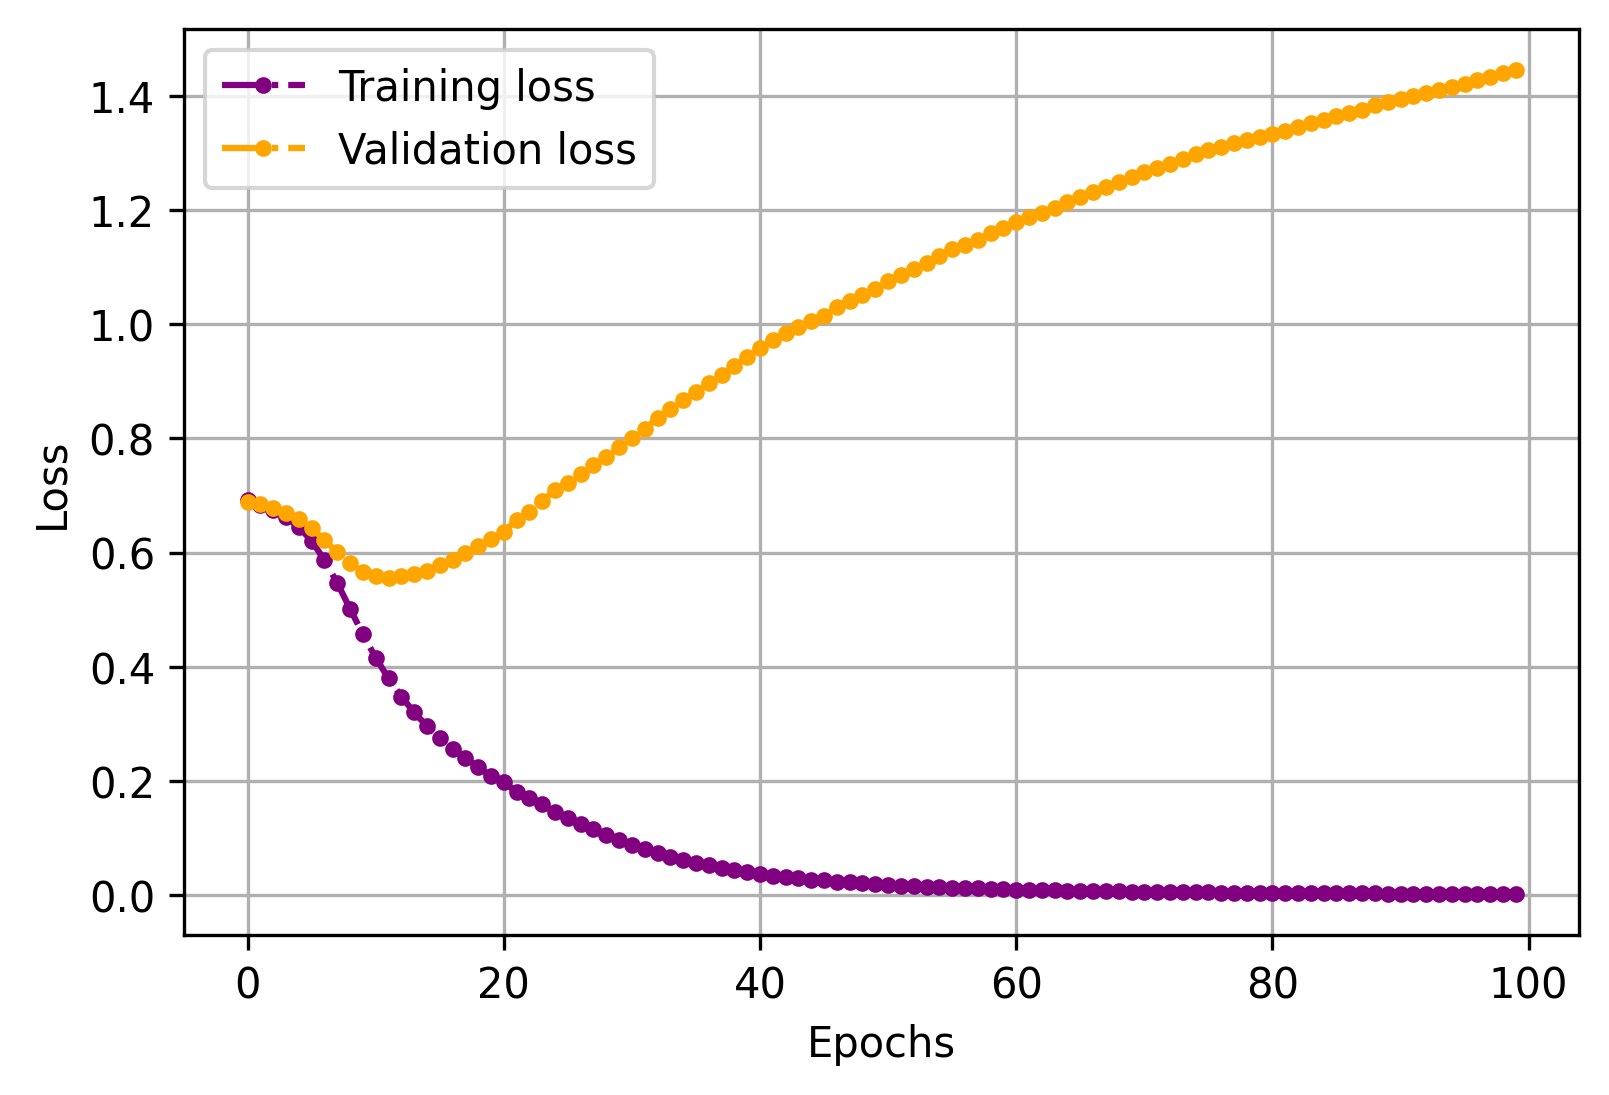

In [31]:
fig, axis = plt.subplots(dpi=300)
axis.plot(training_statistics.history['accuracy'], ls='-', marker='.', label='Training', color='purple')
axis.plot(training_statistics.history['val_accuracy'], ls='-', marker='.', label='Validation', color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()


fig, axis = plt.subplots(dpi=300)
axis.plot(training_statistics.history['loss'], ls='-.', marker='.', label='Training loss', color='purple')
axis.plot(training_statistics.history['val_loss'], ls='-.', marker='.', label='Validation loss', color='orange')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

So while the accuracy for the training data became 1 and the its loss function was reduced to 0, the loss function of the validation data starts to rise after about 15 epochs and its accuracy is going down. 

This behavior is called **over fitting** and is the reason why validation data is so important. Over fitting in machine learning typically happens for the same reason as for a regular fit you are more familiar with. If the number of your data points is small compared to the number of parameters you over fit your data. This means your model can precisely remember how your data you are fitting looked like. Hence, it performs very well on this particular set of images, but performs worse on any other data. 

To avoid over fitting few different techniques can be applied. One thing which we can do is adding so called drop out layers to our network. Dropout layer randomly set a fraction of our layer weights to zero. In this way we can prevent over fitting.

In [32]:
from tensorflow.keras.layers import Dropout

So let us add two drop out layers and repeat the exercise from above:

In [33]:
my_first_nn = Sequential()
my_first_nn.add(Flatten(input_shape=(20, 16, 1)))
my_first_nn.add(Dense(100, activation='relu'))
my_first_nn.add(Dropout(0.1))
my_first_nn.add(Dense(50, activation='relu'))
my_first_nn.add(Dropout(0.2))
my_first_nn.add(Dense(2, activation='softmax'))

my_first_nn.compile(loss=keras.losses.binary_crossentropy, 
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy']
                   )


my_first_nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               32100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 102       
                                                                 
Total params: 37,252
Trainable params: 37,252
Non-trai

In [34]:
training_statistics = my_first_nn.fit(images_training, 
                                      labels_training, 
                                      batch_size=batch_size, 
                                      epochs=epochs,  
                                      validation_data=(images_validation, labels_validation),
                                     )

Epoch 1/100
7/7 [==============================] - 1s 24ms/step - loss: 0.6914 - accuracy: 0.5537 - val_loss: 0.6896 - val_accuracy: 0.6050
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.6450 - val_loss: 0.6843 - val_accuracy: 0.6750
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6777 - accuracy: 0.7362 - val_loss: 0.6780 - val_accuracy: 0.7050
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6680 - accuracy: 0.7625 - val_loss: 0.6687 - val_accuracy: 0.7150
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6544 - accuracy: 0.7975 - val_loss: 0.6558 - val_accuracy: 0.7350
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6338 - accuracy: 0.8062 - val_loss: 0.6382 - val_accuracy: 0.7350
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6094 - accuracy: 0.8125 - val_loss: 0.6165 - val_accuracy: 0.7450
Epoch 8/100
7/7 [=========

7/7 [==============================] - 0s 6ms/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.9177 - val_accuracy: 0.7450
Epoch 60/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.9246 - val_accuracy: 0.7450
Epoch 61/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.9343 - val_accuracy: 0.7450
Epoch 62/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.9477 - val_accuracy: 0.7400
Epoch 63/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.9524 - val_accuracy: 0.7450
Epoch 64/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.9595 - val_accuracy: 0.7500
Epoch 65/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.9679 - val_accuracy: 0.7450
Epoch 66/100
7/7 [===============

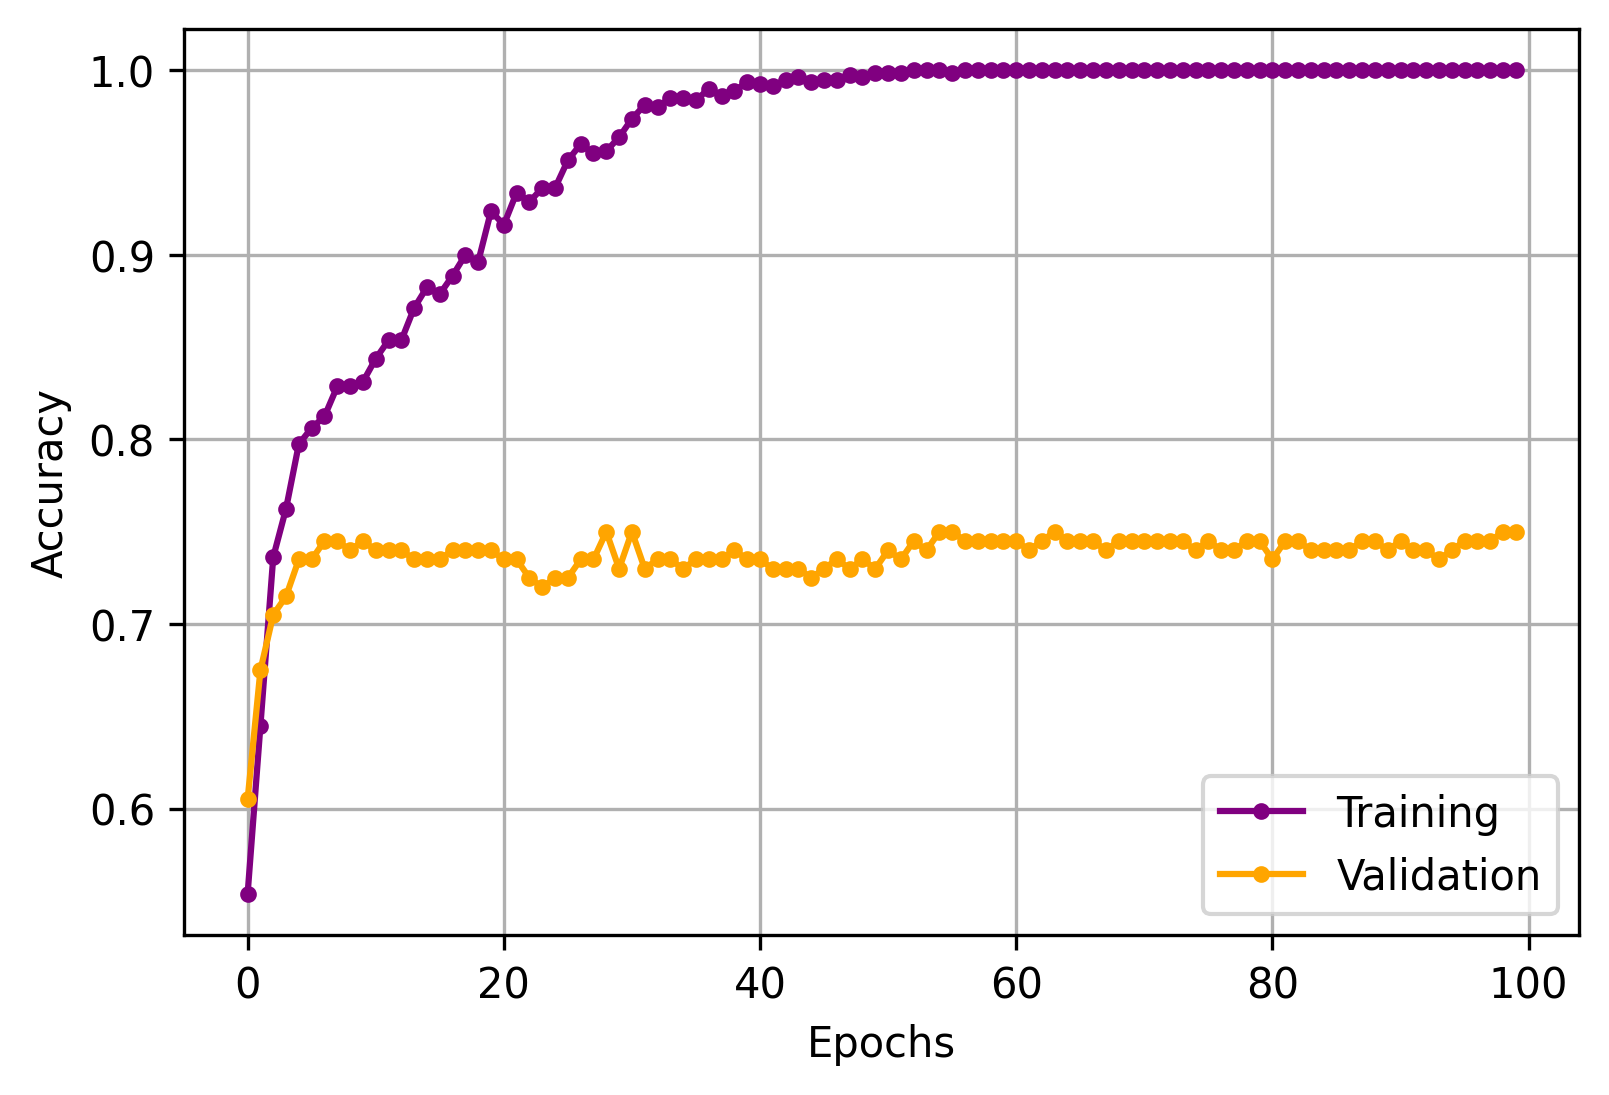

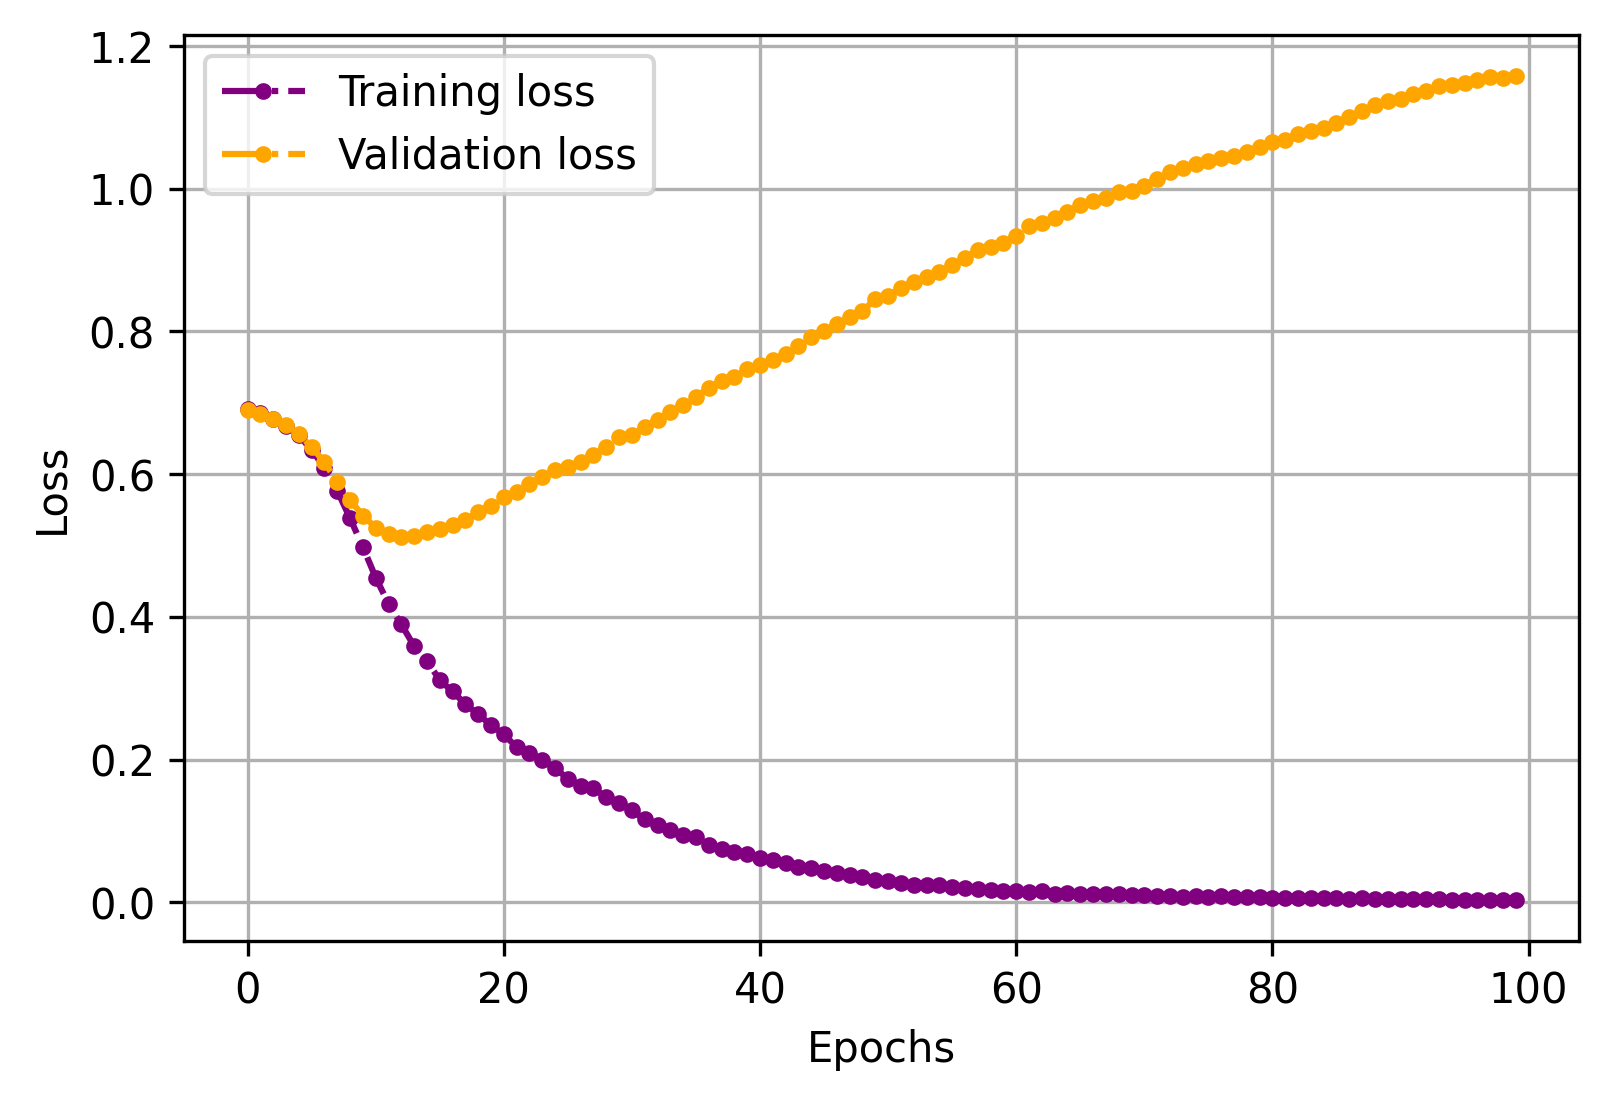

In [35]:
fig, axis = plt.subplots(dpi=300)
axis.plot(training_statistics.history['accuracy'], ls='-', marker='.', label='Training', color='purple')
axis.plot(training_statistics.history['val_accuracy'], ls='-', marker='.', label='Validation', color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()


fig, axis = plt.subplots(dpi=300)
axis.plot(training_statistics.history['loss'], ls='-.', marker='.', label='Training loss', color='purple')
axis.plot(training_statistics.history['val_loss'], ls='-.', marker='.', label='Validation loss', color='orange')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

So it looks like that adding some drop out layer did not help as our statistics is simple to small. Hence let us simulate now 100 k instead of 1 k events per source position:

In [34]:
n_events = 10**5
n_ph = 25
photon_charge_resolution = 0.3
photon_charge_threshold = 0.15  
fraction_training = 0.8

offsets_n, times_n, channel_n, charge_n = neutron_model.generate_events(n_events, 
                                                                        n_ph,
                                                                        photon_charge_resolution,
                                                                        photon_charge_threshold,
                                                                       )

offsets_bkg, times_bkg, channel_bkg, charge_bkg = bkg_model.generate_events(n_events, 
                                                                            n_ph,
                                                                            photon_charge_resolution,
                                                                            photon_charge_threshold,
                                                                           )

# Image creation:
images_n = neutron_model.make_sample(offsets_n, 
                                     times_n, 
                                     channel_n, 
                                     charge_n, 
                                     time_bins=np.arange(0, 32.1, 2)
                                    )
images_bkg = bkg_model.make_sample(offsets_bkg, 
                                   times_bkg, 
                                   channel_bkg, 
                                   charge_bkg, 
                                   time_bins=np.arange(0, 32.1, 2)
                                  )

# Image processing, labeling and splitting:
max_charge_n = np.max(images_n)
images_n /= max_charge_n

max_charge_bkg = np.max(images_bkg)
images_bkg /= max_charge_bkg

assert len(images_n) == len(images_bkg)
n_events = len(images_n)

# Make common image buffer:
images = np.concatenate([images_n, images_bkg])

# Create labels for images:
image_labels = np.zeros((2*n_events, 2), dtype=np.int8)
image_labels[:n_events, 0] = 1
image_labels[n_events:, 1] = 1

# Schuffel:
inds = np.arange(0, 2*n_events, 1)
np.random.shuffle(inds)
images = images[inds]
image_labels = image_labels[inds]

n_training = int(n_events*fraction_training)
images_training = images[:n_training]
labels_training = image_labels[:n_training]

n_valid = n_events - n_training
images_validation = images[-n_valid:]
labels_validation = image_labels[-n_valid:]

In [35]:
my_first_nn = Sequential()
my_first_nn.add(Flatten(input_shape=(20, 16, 1)))
my_first_nn.add(Dense(100, activation='relu'))
my_first_nn.add(Dense(50, activation='relu'))
my_first_nn.add(Dense(2, activation='softmax'))

my_first_nn.compile(loss=keras.losses.binary_crossentropy, 
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy']
                   )


my_first_nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 320)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               32100     
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dense_8 (Dense)             (None, 2)                 102       
                                                                 
Total params: 37,252
Trainable params: 37,252
Non-trainable params: 0
_________________________________________________________________


In [38]:
training_statistics = my_first_nn.fit(images_training, 
                                      labels_training, 
                                      batch_size=batch_size, 
                                      epochs=epochs,  
                                      validation_data=(images_validation, labels_validation),
                                     )

Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4910 - accuracy: 0.7662 - val_loss: 0.4586 - val_accuracy: 0.7790
Epoch 2/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4509 - accuracy: 0.7852 - val_loss: 0.4469 - val_accuracy: 0.7893
Epoch 3/100
625/625 [==============================] - 2s 2ms/step - loss: 0.4383 - accuracy: 0.7920 - val_loss: 0.4424 - val_accuracy: 0.7901
Epoch 4/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4217 - accuracy: 0.8009 - val_loss: 0.4430 - val_accuracy: 0.7907
Epoch 5/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4038 - accuracy: 0.8108 - val_loss: 0.4464 - val_accuracy: 0.7890
Epoch 6/100
625/625 [==============================] - 2s 3ms/step - loss: 0.3871 - accuracy: 0.8219 - val_loss: 0.4529 - val_accuracy: 0.7874
Epoch 7/100
625/625 [==============================] - 2s 3ms/step - loss: 0.3732 - accuracy: 0.8292 - val_loss: 0.4579 - val_accuracy: 0.7857

Epoch 58/100
625/625 [==============================] - 2s 3ms/step - loss: 0.1748 - accuracy: 0.9258 - val_loss: 1.0348 - val_accuracy: 0.7613
Epoch 59/100
625/625 [==============================] - 2s 3ms/step - loss: 0.1750 - accuracy: 0.9259 - val_loss: 1.0381 - val_accuracy: 0.7595
Epoch 60/100
625/625 [==============================] - 2s 3ms/step - loss: 0.1730 - accuracy: 0.9267 - val_loss: 1.0378 - val_accuracy: 0.7559
Epoch 61/100
625/625 [==============================] - 2s 3ms/step - loss: 0.1692 - accuracy: 0.9288 - val_loss: 1.0716 - val_accuracy: 0.7573
Epoch 62/100
625/625 [==============================] - 2s 2ms/step - loss: 0.1678 - accuracy: 0.9299 - val_loss: 1.0978 - val_accuracy: 0.7550
Epoch 63/100
625/625 [==============================] - 2s 3ms/step - loss: 0.1672 - accuracy: 0.9297 - val_loss: 1.1141 - val_accuracy: 0.7560
Epoch 64/100
625/625 [==============================] - 2s 3ms/step - loss: 0.1641 - accuracy: 0.9313 - val_loss: 1.0923 - val_accuracy:

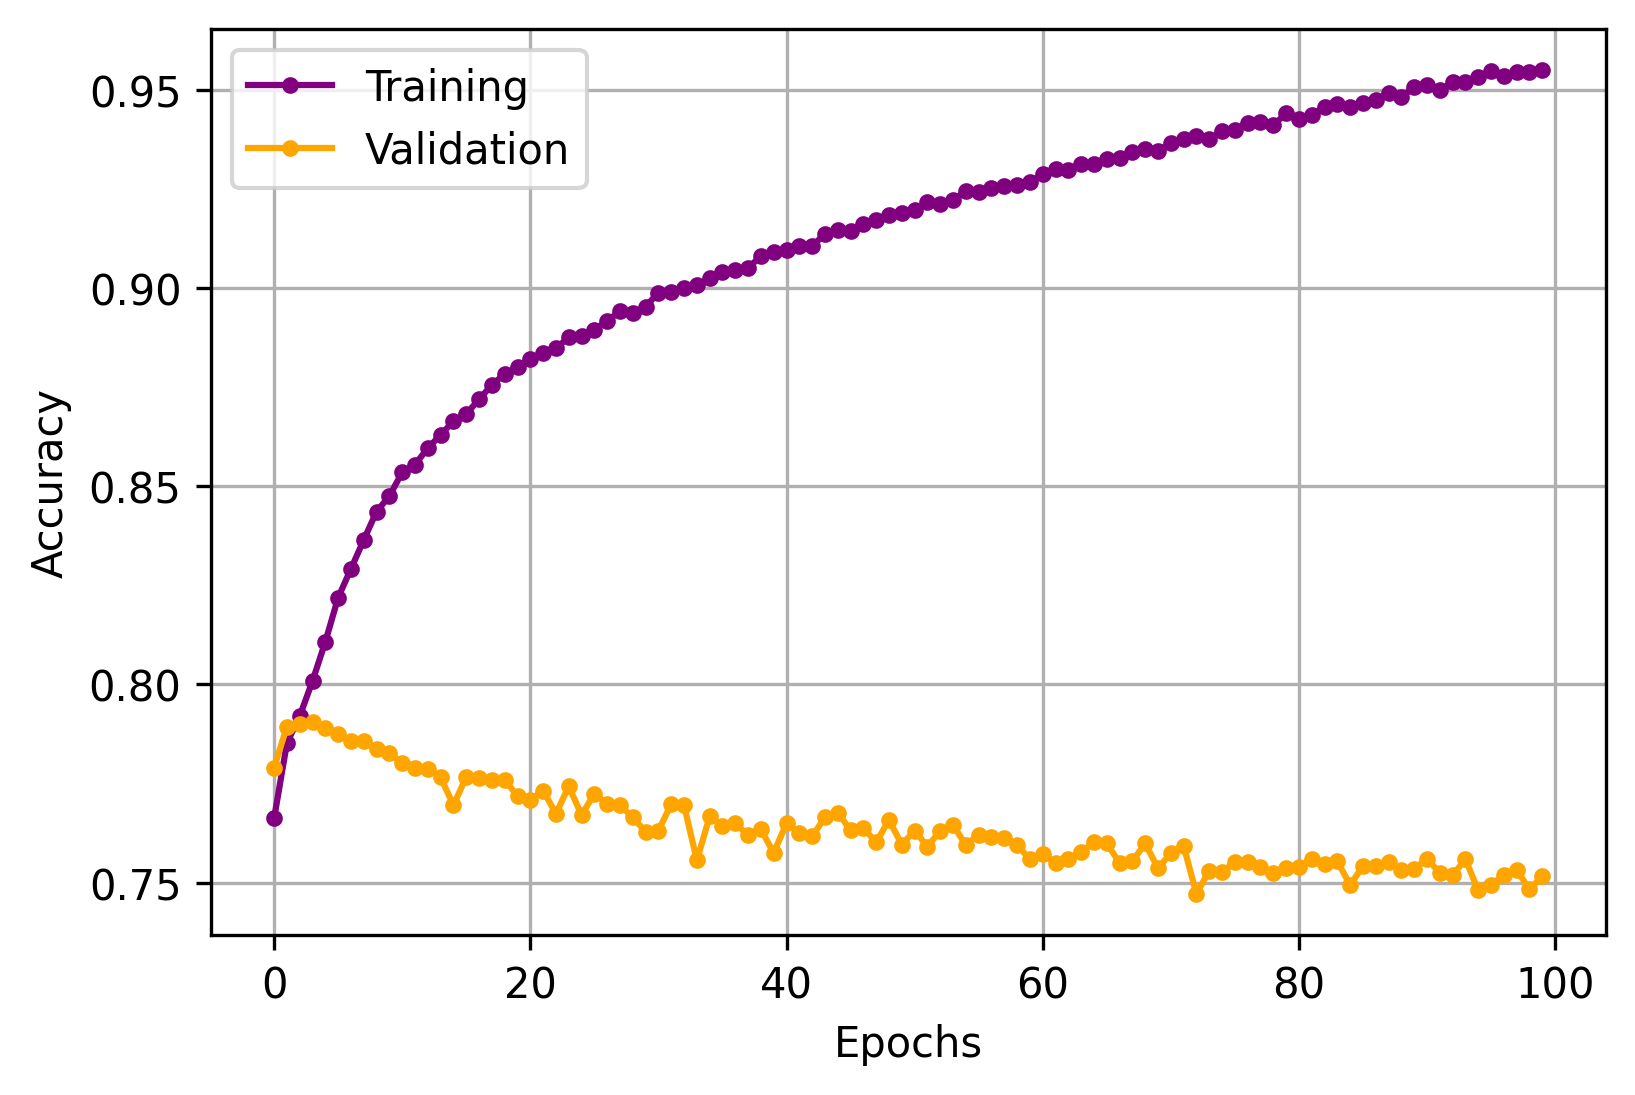

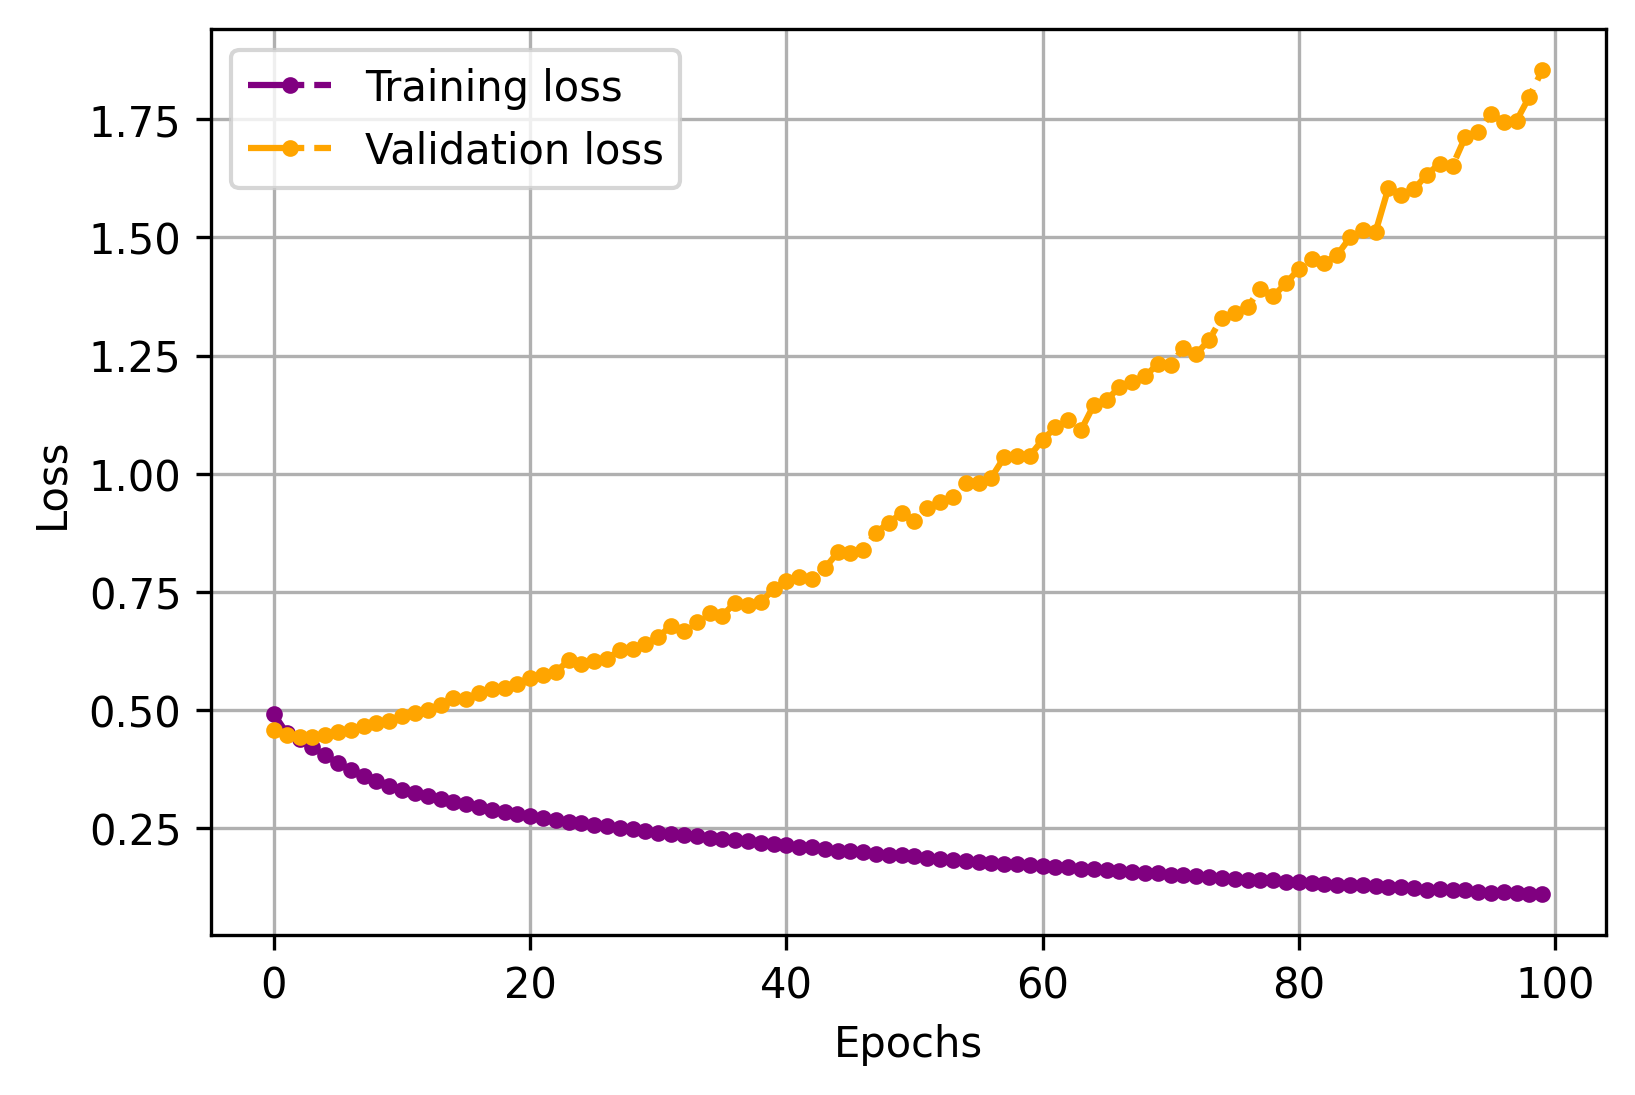

In [39]:
fig, axis = plt.subplots(dpi=300)
axis.plot(training_statistics.history['accuracy'], ls='-', marker='.', label='Training', color='purple')
axis.plot(training_statistics.history['val_accuracy'], ls='-', marker='.', label='Validation', color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()


fig, axis = plt.subplots(dpi=300)
axis.plot(training_statistics.history['loss'], ls='-.', marker='.', label='Training loss', color='purple')
axis.plot(training_statistics.history['val_loss'], ls='-.', marker='.', label='Validation loss', color='orange')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

Also the larger statistics did not lead to a better result. Hence, in this case one would use the model at the point where we reached the minimal validation loss and the highest validation accuracy.

# Moving to Convolutional Neural Networks:

So far we only achieved a validation accuracy of about 80 % let us see if we can do better with a Convolutional Neural Network. As the name suggest CNNs are using convolutions between kernel matrices and images to extract certain features of the image. The idea behind this type of networks can be understood when looking at typical applications in image processing. In image processing specific filter kernels like [Canny edge detection](https://en.wikipedia.org/wiki/Canny_edge_detection) can be used to detect edges in images. In addition the convolution will group together spatially important information.

Other operation like max pooling help to reconstruct the sharpen the image and to extract the sharpest and most relevant features in a neural network.... Further, are max pooling layers reducing the number of parameters needed in subsequent layers. 

The general concept is to have multiple layers of convolution and max pooling after another before calling a few densely connected layers. This concept is based on the idea that e.g. in order to recognize a face you have to first learn how to identify lines and contours before you can identify mid-size objects like eyes, mouth and nose and at the very end you can identify entire face. 

So let us now import the required layers from tensorflow. As our problem is a two dimensional one (PMT channel/ azimuthal angle versus time) we have to import the 2D versions of the corresponding algorithms:

In [36]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [37]:
my_cnn_model = Sequential()
my_cnn_model.add(Conv2D(8, (3,3), input_shape=(20, 16, 1), activation='relu'))
my_cnn_model.add(MaxPooling2D(2,2))
my_cnn_model.add(Conv2D(16, (3,3), input_shape=(20, 16, 1), activation='relu'))
my_cnn_model.add(MaxPooling2D(2,2))
my_cnn_model.add(Flatten())
my_cnn_model.add(Dense(200, activation='relu'))
my_cnn_model.add(Dense(100, activation='relu'))
my_cnn_model.add(Dense(2, activation='softmax'))
my_cnn_model.compile(loss=keras.losses.binary_crossentropy, 
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy']
                   )
my_cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 14, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 7, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 5, 16)          1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 2, 16)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 96)                0         
                                                                 
 dense_9 (Dense)             (None, 200)              

Let train this first CNN with the same data from before and compare the accuracy:

In [38]:
batch_size = 1024
epochs = 30

In [43]:
cnn_statistics = my_cnn_model.fit(images_training, 
                                  labels_training, 
                                  batch_size=batch_size, 
                                  epochs=epochs,  
                                  validation_data=(images_validation, labels_validation),
                                 )

Epoch 1/30
79/79 [==============================] - 6s 64ms/step - loss: 0.6357 - accuracy: 0.6390 - val_loss: 0.5527 - val_accuracy: 0.7204
Epoch 2/30
79/79 [==============================] - 5s 62ms/step - loss: 0.5154 - accuracy: 0.7490 - val_loss: 0.4906 - val_accuracy: 0.7685
Epoch 3/30
79/79 [==============================] - 5s 62ms/step - loss: 0.4855 - accuracy: 0.7724 - val_loss: 0.5062 - val_accuracy: 0.7581
Epoch 4/30
79/79 [==============================] - 5s 62ms/step - loss: 0.4747 - accuracy: 0.7777 - val_loss: 0.4661 - val_accuracy: 0.7850
Epoch 5/30
79/79 [==============================] - 5s 63ms/step - loss: 0.4660 - accuracy: 0.7834 - val_loss: 0.4636 - val_accuracy: 0.7841
Epoch 6/30
79/79 [==============================] - 5s 61ms/step - loss: 0.4597 - accuracy: 0.7868 - val_loss: 0.4604 - val_accuracy: 0.7848
Epoch 7/30
79/79 [==============================] - 5s 62ms/step - loss: 0.4551 - accuracy: 0.7892 - val_loss: 0.4539 - val_accuracy: 0.7890
Epoch 8/30
79

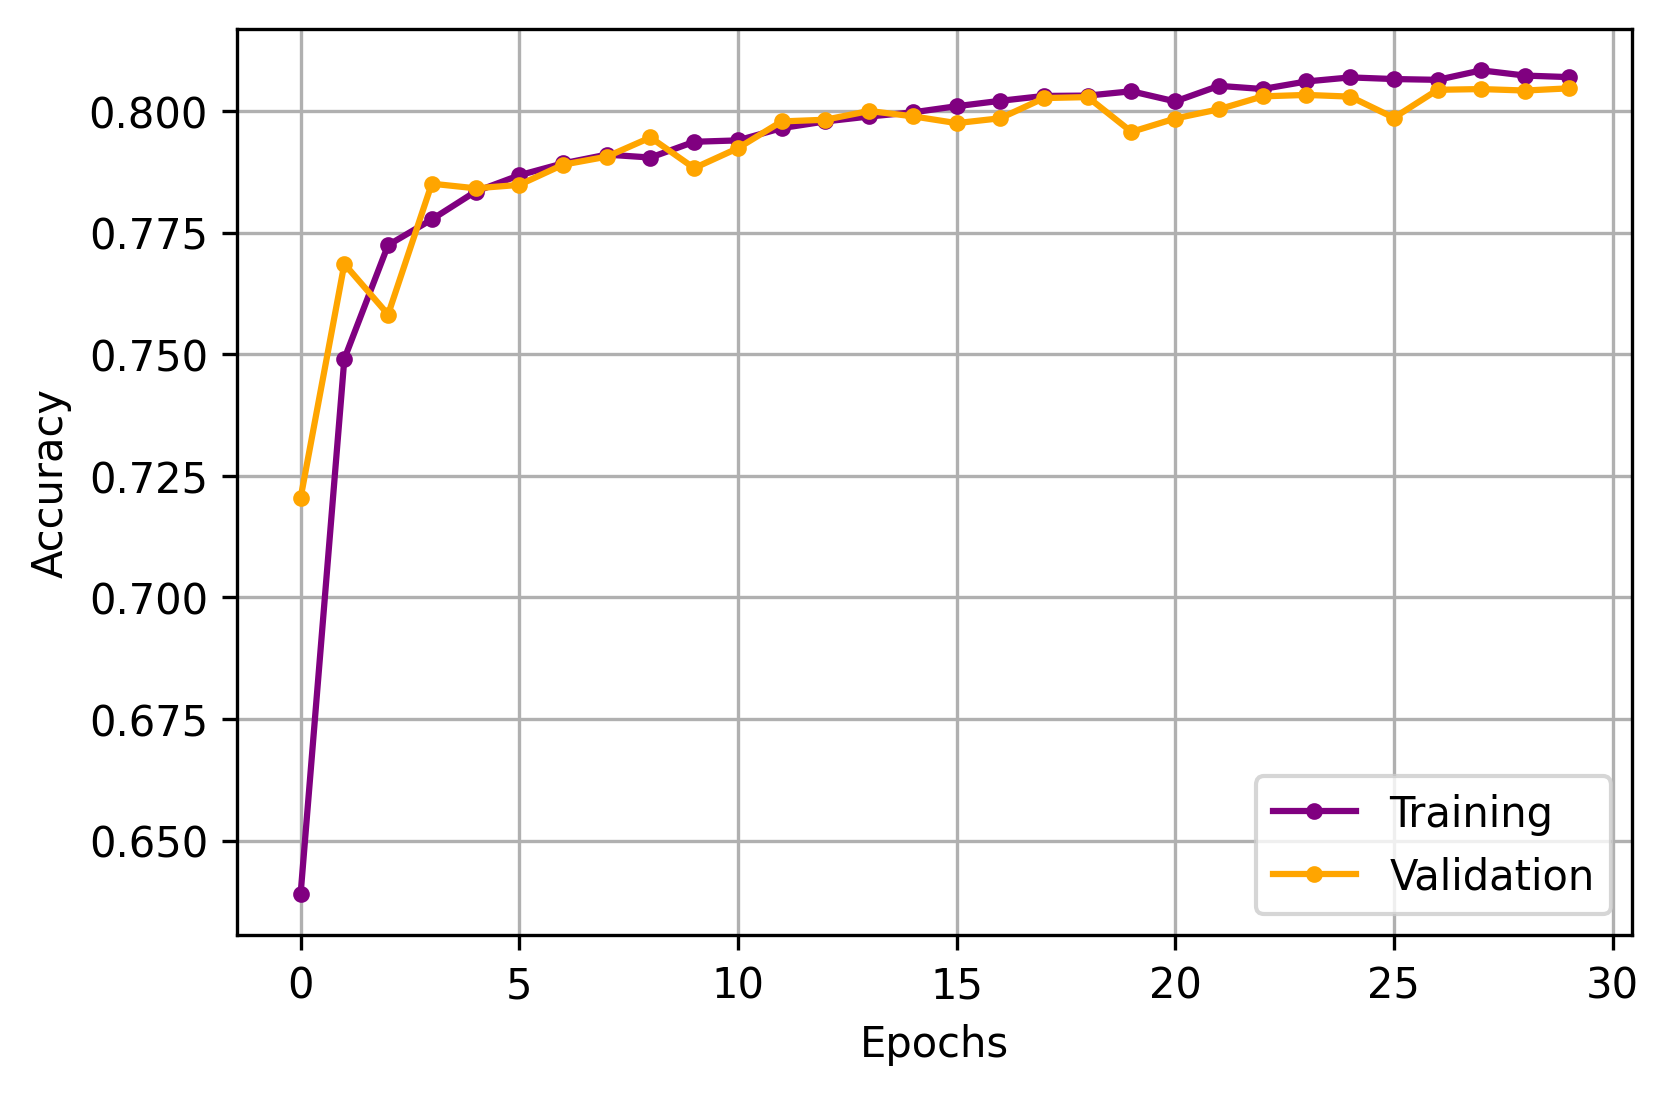

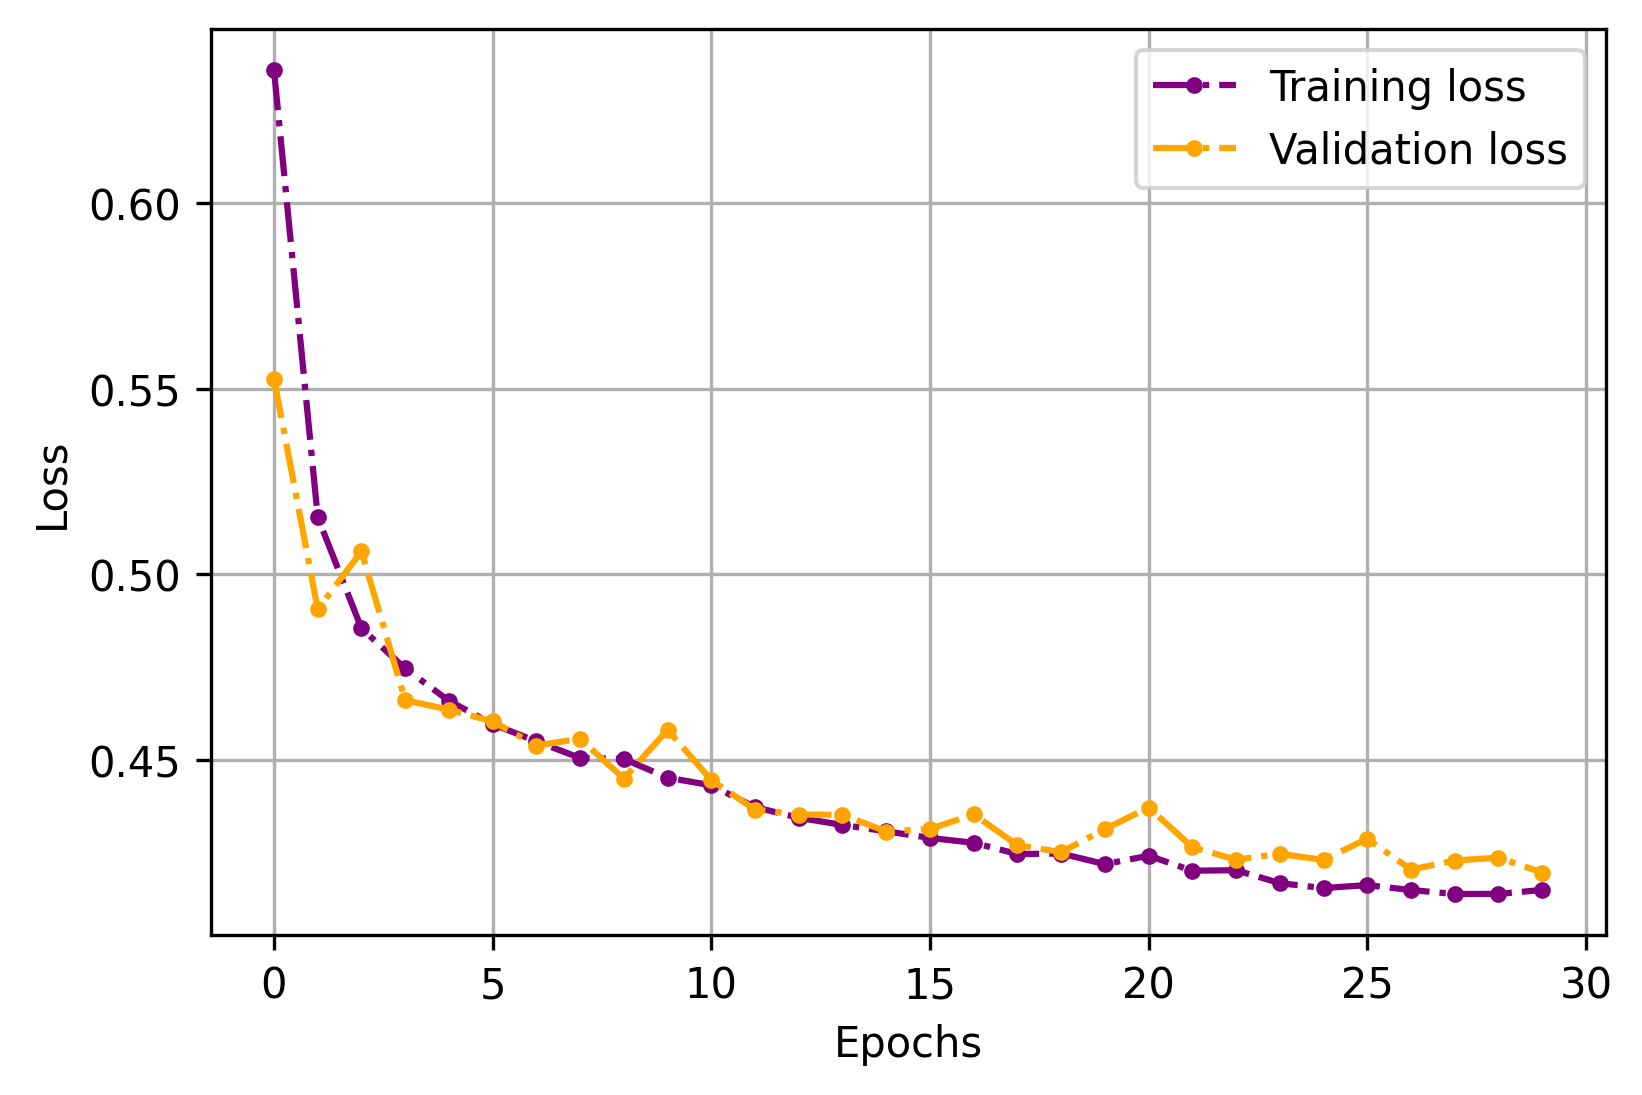

In [44]:
fig, axis = plt.subplots(dpi=300)
axis.plot(cnn_statistics.history['accuracy'], ls='-', marker='.', label='Training', color='purple')
axis.plot(cnn_statistics.history['val_accuracy'], ls='-', marker='.', label='Validation', color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()


fig, axis = plt.subplots(dpi=300)
axis.plot(cnn_statistics.history['loss'], ls='-.', marker='.', label='Training loss', color='purple')
axis.plot(cnn_statistics.history['val_loss'], ls='-.', marker='.', label='Validation loss', color='orange')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

Compared to our simple model we achieve a slightly higher efficiency be using almost the same number of parameters. Once we found and trained our model we can also easily store it to disk via...

In [45]:
my_cnn_model.save('./data/cnn_model_simple_approach.hdf5')

...and load it again with:

In [46]:
my_cnn_model.load_weights('./data/cnn_model_simple_approach.hdf5')

## Callback functions:

Sometimes it is useful to have some more control over the training procedure of our CNNs. You may want to stop training after a fixed amount of time or take checkpoints of your current model weights in case your notebook crashes. For this purpose we can define different callback functions which we can supply. 

Tensorflow also others some already predefined callback functions. Let us have a look at the `ModelCheckpoint` callback function. We can simply define the callback function as:

In [39]:
checkpoint_names = './data/checkpoints/my_cnn_model_check_point_{epoch:04d}.ckpt'


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_names, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=False,
    save_freq=len(images_training)//batch_size//2, 
)




This call back function will now store our model weights twice per epoch. Let compile and retrain our model:

In [40]:
my_cnn_model = Sequential()
my_cnn_model.add(Conv2D(8, (3,3), input_shape=(20, 16, 1), activation='relu'))
my_cnn_model.add(MaxPooling2D(2,2))
my_cnn_model.add(Conv2D(16, (3,3), input_shape=(20, 16, 1), activation='relu'))
my_cnn_model.add(MaxPooling2D(2,2))
my_cnn_model.add(Flatten())
my_cnn_model.add(Dense(200, activation='relu'))
my_cnn_model.add(Dense(100, activation='relu'))
my_cnn_model.add(Dense(2, activation='softmax'))
my_cnn_model.compile(loss=keras.losses.binary_crossentropy, 
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy']
                   )

In [72]:
cnn_statistics = my_cnn_model.fit(images_training, 
                                  labels_training, 
                                  batch_size=batch_size, 
                                  epochs=epochs,  
                                  validation_data=(images_validation, labels_validation),
                                  callbacks=[cp_callback,]
                                 )

Epoch 1/30
38/79 [=============>................] - ETA: 2s - loss: 0.6709 - accuracy: 0.5883
Epoch 1: saving model to ./data/checkpoints/my_cnn_model_check_point_0001.ckpt
77/79 [============================>.] - ETA: 0s - loss: 0.6358 - accuracy: 0.6306
Epoch 1: saving model to ./data/checkpoints/my_cnn_model_check_point_0001.ckpt
79/79 [==============================] - 6s 64ms/step - loss: 0.6346 - accuracy: 0.6320 - val_loss: 0.5821 - val_accuracy: 0.6958
Epoch 2/30
37/79 [=============>................] - ETA: 2s - loss: 0.5405 - accuracy: 0.7275
Epoch 2: saving model to ./data/checkpoints/my_cnn_model_check_point_0002.ckpt
76/79 [===========================>..] - ETA: 0s - loss: 0.5229 - accuracy: 0.7436
Epoch 2: saving model to ./data/checkpoints/my_cnn_model_check_point_0002.ckpt
79/79 [==============================] - 6s 71ms/step - loss: 0.5224 - accuracy: 0.7443 - val_loss: 0.5000 - val_accuracy: 0.7639
Epoch 3/30
36/79 [============>.................] - ETA: 2s - loss: 0.

79/79 [==============================] - 6s 72ms/step - loss: 0.4277 - accuracy: 0.8008 - val_loss: 0.4304 - val_accuracy: 0.7963
Epoch 19/30
20/79 [======>.......................] - ETA: 3s - loss: 0.4235 - accuracy: 0.8032
Epoch 19: saving model to ./data/checkpoints/my_cnn_model_check_point_0019.ckpt
59/79 [=====================>........] - ETA: 1s - loss: 0.4267 - accuracy: 0.8025
Epoch 19: saving model to ./data/checkpoints/my_cnn_model_check_point_0019.ckpt
79/79 [==============================] - 6s 70ms/step - loss: 0.4257 - accuracy: 0.8027 - val_loss: 0.4286 - val_accuracy: 0.7979
Epoch 20/30
19/79 [======>.......................] - ETA: 3s - loss: 0.4236 - accuracy: 0.8035
Epoch 20: saving model to ./data/checkpoints/my_cnn_model_check_point_0020.ckpt
58/79 [=====================>........] - ETA: 1s - loss: 0.4259 - accuracy: 0.8019
Epoch 20: saving model to ./data/checkpoints/my_cnn_model_check_point_0020.ckpt
79/79 [==============================] - 6s 72ms/step - loss: 0.

To load one of your stored checkpoints you can load the weights just like before via:

In [41]:
my_cnn_model.load_weights('./data/checkpoints/my_cnn_model_check_point_0013.ckpt')

Other then creating many checkpoints you can also set `save_best_only=True` and so only the best model according to our validation data is stored.

In [ ]:
import time


class TimerCallback(keras.callbacks.Callback):
    """Simple callback function which will time the training procedure.
    Based on the tensorflow example which can be found in
    https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
    """

    def on_train_begin(self, logs=None):
        self.epoch_starts = []
        self.epoch_ends = []
        self.training_starts_at = time.time()
        print(f'Test {logs.keys()}')
        
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_starts.append(time.time()-self.training_starts_at)
        print(f'Test {logs.keys()}')
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_ends.append(time.time()-self.training_starts_at)
        print(f'Test {logs.keys()}')
        
    def on_train_end(self, logs=None):
        print(f'End {logs.keys()}')
        
        
        
class TrainingStatsCallback(keras.callbacks.Callback):
    """Simple callback function which times the training procedure and 
    stores training stats.
    https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
    """

    def on_train_begin(self, logs=None):
        self.epoch_starts = []
        self.epoch_ends = []
        self.training_starts_at = time.time()
        
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_starts.append(time.time()-self.training_starts_at)
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_ends.append(time.time()-self.training_starts_at)

# More complex model:

In [39]:
num_classes = 2

In [40]:
nveto_class_model = Sequential()

pool_size = (3, 3)

nveto_class_model.add(Conv2D(8, 
                             kernel_size=(3, 3), 
                             activation='relu', 
                             input_shape=(20, 16, 1),
                             padding='same' 
                            )
                     )

nveto_class_model.add(MaxPooling2D(pool_size,
                                   padding='same'))

nveto_class_model.add(Conv2D(16, 
                             kernel_size=(3, 3), 
                             activation='relu', 
                             padding='same' 
                            )
                     )

nveto_class_model.add(MaxPooling2D(pool_size,
                                   padding='same'))

nveto_class_model.add(Conv2D(32, 
                             kernel_size=(3, 3), 
                             activation='relu', 
                             padding='same' 
                            )
                     )

#nveto_class_model.add(MaxPooling2D(pool_size,
#                                   padding='same'))
#
    
nveto_class_model.add(Flatten())
nveto_class_model.add(Dense(64, activation='relu'))
#nveto_class_model.add(Dropout(0.3))
nveto_class_model.add(Dense(num_classes, activation='softmax'))
nveto_class_model.compile(loss=keras.losses.binary_crossentropy, 
                          optimizer=keras.optimizers.Adam(),
                          metrics=['accuracy'])


In [43]:
nveto_class_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 20, 16, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 6, 8)          0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 6, 16)          1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 2, 16)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 2, 32)          4640      
                                                                 
 flatten_1 (Flatten)         (None, 192)              

In [41]:
batch_size = 256
epochs = 1

In [42]:
nveto_train = nveto_class_model.fit(images_training, 
                                    labels_training, 
                                    batch_size=batch_size, 
                                    epochs=epochs, 
                                    verbose=1, 
                                    validation_data=(images_validation, labels_validation),
                                   )

4/4 [==============================] - 2s 88ms/step - loss: 0.6926 - accuracy: 0.5200 - val_loss: 0.6896 - val_accuracy: 0.5017


In [46]:
in_array = np.array([[1,2,3], [4,5,6], [7,8,9]])

In [49]:
b

<tf.Tensor: shape=(9, 9), dtype=int32, numpy=
array([[1, 2, 3, 1, 2, 3, 1, 2, 3],
       [4, 5, 6, 4, 5, 6, 4, 5, 6],
       [7, 8, 9, 7, 8, 9, 7, 8, 9],
       [1, 2, 3, 1, 2, 3, 1, 2, 3],
       [4, 5, 6, 4, 5, 6, 4, 5, 6],
       [7, 8, 9, 7, 8, 9, 7, 8, 9],
       [1, 2, 3, 1, 2, 3, 1, 2, 3],
       [4, 5, 6, 4, 5, 6, 4, 5, 6],
       [7, 8, 9, 7, 8, 9, 7, 8, 9]], dtype=int32)>

In [50]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9]])
b = tf.tile(a, [3, 3])
result = b[1:8, 1:8]
result

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[5, 6, 4, 5, 6, 4, 5],
       [8, 9, 7, 8, 9, 7, 8],
       [2, 3, 1, 2, 3, 1, 2],
       [5, 6, 4, 5, 6, 4, 5],
       [8, 9, 7, 8, 9, 7, 8],
       [2, 3, 1, 2, 3, 1, 2],
       [5, 6, 4, 5, 6, 4, 5]], dtype=int32)>

In [297]:
class MyCircularPadding(tf.keras.layers.Layer):
    """Layer which performs a circular padding along the angular axis
    and uses the specified padding along the time axis.
    """
    def __init__(self, 
                 filter_height, 
                 filter_width,
                 stride_height=1,
                 stride_width=1,
                 **kwargs):
        super(MyCircularPadding, self).__init__(**kwargs)
        self.filter_height = filter_height
        self.filter_width = filter_width
        self.stride_height = stride_height
        self.stride_width = stride_width
        

    def build(self, input_shape):
        self._input_shape = input_shape
        self._in_height,  self._in_width  = input_shape
        # Compute padding boundaries taken from tensorflow documentation. 
        if (self._in_height % self.stride_height == 0):
            pad_along_height = max(self.filter_height - self.stride_height, 0)
        else:
            pad_along_height = max(self.filter_height - (self._in_height % self.stride_height), 0)
        if (self._in_width % self.stride_width == 0):
            pad_along_width = max(self.filter_width - self.stride_width, 0)
        else:
            pad_along_width = max(self.filter_width - (self._in_width % self.stride_width), 0)
            
        self.pad_top = pad_along_height // 2
        self.pad_bottom = pad_along_height - self.pad_top
        self.pad_left = pad_along_width // 2
        self.pad_right = pad_along_width - self.pad_left

    def call(self, inputs):
        padding = ((self.pad_top, self.pad_bottom), 
                   (self.pad_left, self.pad_right))
        print(tf.shape(inputs))
        output = tf.pad(tf.shape(inputs), padding, "CONSTANT")
        return inputs

In [298]:
test = MyCircularPadding(3, 3)

In [299]:
test(test_array)

tf.Tensor([3 3], shape=(2,), dtype=int32)


InvalidArgumentError: Exception encountered when calling layer "my_circular_padding_75" (type MyCircularPadding).

The first dimension of paddings must be the rank of inputs[2,2] [2] [Op:Pad]

Call arguments received:
  • inputs=tf.Tensor(shape=(3, 3), dtype=int64)

In [288]:
test_array = np.array([[1,2,3], [4,5,6], [7,8,9]])
test_array2 = np.array([[[1,2,3, 4], [4,5,6,7]], [[1,2,3, 4], [4,5,6,7]]])

test = Sequential()
test.add(tf.keras.layers.InputLayer(input_shape=test_array2[0].shape))
test.add(MyCircularPadding(3, 3))

Tensor("my_circular_padding_71/Shape:0", shape=(3,), dtype=int32)


ValueError: Exception encountered when calling layer "my_circular_padding_71" (type MyCircularPadding).

in user code:

    File "/tmp/jobs/19033532/ipykernel_1051/2317217316.py", line 40, in call  *
        output = tf.pad(tf.shape(inputs), padding, "CONSTANT")

    ValueError: Shape must be rank 2 but is rank 1 for '{{node my_circular_padding_71/Pad}} = Pad[T=DT_INT32, Tpaddings=DT_INT32](my_circular_padding_71/Shape_1, my_circular_padding_71/Pad/paddings)' with input shapes: [3], [2,2].


Call arguments received:
  • inputs=tf.Tensor(shape=(None, 2, 4), dtype=float32)

In [274]:
test.summary()

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_circular_padding_64 (MyC  (None, 2, 4)             0         
 ircularPadding)                                                 
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [232]:
test.predict(test_array2[:])

((1, 1), (1, 1))


array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 2., 3., 4., 0.],
       [0., 4., 5., 6., 7., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [237]:
tf.keras.layers.ZeroPadding2D??

In [191]:
images[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 

In [267]:
tf.pad(tf.zeros((5, 2,4)), tf.constant([[0,0], [1, 1,], [2, 2]]), 'CONSTANT')

<tf.Tensor: shape=(5, 4, 8), dtype=float32, numpy=
array([[[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)>

In [209]:
tf.add(tf.pad(tf.zeros((2,2)), tf.constant([[1, 1,], [2, 2]]), 'CONSTANT'), 1)

<tf.Tensor: shape=(4, 6), dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.]], dtype=float32)>